#  The Eight Schools model illustration

In [1]:
!pip install torch pystan seaborn matplotlib pandas numpy

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import torch
from torch.nn.functional import softplus
from torch.distributions import Normal, Cauchy

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    env = torch.cuda
    device = torch.device('cuda')
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    env = torch
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [4]:
import sys

import numpy as np
import random
np.random.seed(seed=0)
random.seed(0)

import pandas as pd

In [5]:
from aux import *
from aux_plt import *
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [6]:
from losses import *
from log_utility import *

# Configuration

In [7]:
# optimization general parmeters
SEED = 123
NITER  = 20000 # number of iterations - around 20k is advised
LR = 0.1

# number of samples used to approximate ELBO term
NSAMPLES = 11

# selected loss: tilted/squared
LOSS = "tilted"
TILTED_Q = 0.2 
# loss-to-utility transformation (bigM: utility=M-loss / id: utility=-loss)
UTIL =  "bigM"
M = (10000.0 if UTIL.lower()=="bigm" else 1.0)

# constructing an approximation to the utility-dependent term:
UTILITY_TERM = "naive" # vi/naive/linearized/jensen
# the utility-dependent term is multiplied by this value: 
#  should be 1/M for linearized and M for the others
UTILITY_TERM_SCALE = (1.0 if "linearized" in UTILITY_TERM else M) #for linearized we use U~=-risk 
# how many samples of latent variables
NSAMPLES_UTILITY_TERM_THETA = 123
# how many samples of y for each latent variable
NSAMPLES_UTILITY_TERM_Y = 11
# update gradients of the utility term in every x iterations
UTILITY_TERM_EVERY_NITER = 1

# finding optimal h:
#  analytical - use Bayes estimator / num - optimize numerically gain / 
#  num-util - optimize numerically a selected approximation to the utility-dependent term.
FIND_H = "analytical"
# choose an approximation to the utility-dependent term, by default == UTILITY_TERM
H_UTILITY_AGGREGATOR = UTILITY_TERM
# respectively, the number of theta and y samples used when optimizing for h
H_NSAMPLES_UTILITY_TERM_THETA = NSAMPLES_UTILITY_TERM_THETA
H_NSAMPLES_UTILITY_TERM_Y = NSAMPLES_UTILITY_TERM_Y

# parameters of the numerical optimizer used to find the optimal h
H_NUMERICAL_MAX_NITER = 10000
H_NUMERICAL_MAX_NITER_TOL = 0.0001
H_NUMERICAL_MAX_NITER_TOL_GOAL = -1
H_NUMERICAL_LR =  0.01
H_NUMERICAL_OPT_SCIPY = False
H_NUMERICAL_START_FROM_PREVIOUS = False

# how often to evaulate (=report losses and (optionally) gains)
EVAL_NITER = 1000
# should we skip the evaluation in terms of gains 
#  (obtained via numerical optimization) and just rely on risks
EVAL_SKIP_GAIN = True

# evaluation parameters (these numbers should be sufficently large 
# if we want to trust our evaluation):
#  number of samples of latent variables
EVAL_NSAMPLES_UTILITY_TERM_THETA = 1000
#  number of samples of y for each latent variable
EVAL_NSAMPLES_UTILITY_TERM_Y = 100
# parameters of the numerical optimization w.r.t. h used in evaluation
EVAL_MAX_NITER = 20000
EVAL_SGD_PREC = 0.0001
EVAL_UTIL = UTIL # loss-to-utility transformation used to evaluate gain   

# Data

In [8]:
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

# Model definition

In [9]:
def jacobian_softplus(x):
       return 1.0/(1.0 + torch.exp(-x))

    
def model_log_prob(data, mu, tau, theta):    
    y = torch.tensor(data["y"], dtype=torch.float32)
    sigma = torch.tensor(data["sigma"], dtype=torch.float32)
    taup = softplus(tau)
    
    lik = Normal(theta, sigma)
    prior_theta = Normal(mu, taup)
    prior_mu = Normal(0.0, 5.0)
    prior_tau = Cauchy(0.0, 5.0)  #half-Cauchy (=2*pdf of Cauchy)
    
    return lik.log_prob(y).sum() \
            + prior_theta.log_prob(theta).sum() \
            + prior_mu.log_prob(mu) \
            + torch.tensor(2.0, dtype=torch.float32).log()+prior_tau.log_prob(taup) \
            + torch.log(jacobian_softplus(tau))

In [10]:
def sample_predictive_y0(data, q_theta, 
                        nsamples_theta=NSAMPLES_UTILITY_TERM_THETA, 
                         nsamples_y=NSAMPLES_UTILITY_TERM_Y):
    """ Returns a tensor with samples     
        (nsamples_y samples of y for each theta x 
         nsamples_theta samples of latent variables).
    """
    sigma = torch.tensor(data["sigma"], dtype=torch.float32)
    
    theta =  q_theta.rsample(torch.Size([nsamples_theta]))
    ys = Normal(theta, sigma).rsample(torch.Size([nsamples_y]))    
    return ys


def sample_predictive_y(data, q_theta, 
                        nsamples_theta=NSAMPLES_UTILITY_TERM_THETA, 
                        nsamples_y=NSAMPLES_UTILITY_TERM_Y):
    """ Returns a tensor with samples (nsamples_y x nsamples_theta).
        Flattents the first two dimensions 
        (samples of y for different thetas) from sample_predictive_y0.
    """    
    ys = sample_predictive_y0(data, q_theta, nsamples_theta, nsamples_y)
    return flatten_first_two_dims(ys)

# Configuring utility-dependent term and optimization w.r.t. h

In [11]:
# include all (training) data points in utility-dependent term
utility_term_mask = torch.ones(schools_dat["J"]).type(env.ByteTensor) 

loss, optimal_h = LossFactory(**globals()).create(LOSS)
print2("<%s> loss: %s with (analytical) h: %s" % (LOSS, loss.__name__, optimal_h.__name__))
        
u = UtilityFactory(**globals()).create(UTIL, loss)
print2("utility: %s" % u.__name__)
        
UTILITY_AGGREGATOR = UtilityAggregatorFactory().create(H_UTILITY_AGGREGATOR)
print2("h utility aggregator: %s" % UTILITY_AGGREGATOR.__name__)
        
H_OPTIMIZER =  HOptimizerFactory(**globals()).create(FIND_H, u=u, 
                                                     optimal_h=optimal_h, 
                                                     utility_aggregator=UTILITY_AGGREGATOR)
print2("h optimizer: %s" % H_OPTIMIZER.__name__)        
        
utility_term = UtilityDependentTermFactory(**globals()).create(UTILITY_TERM, u)
print2("utility-dependent term: %s" % utility_term.__name__)

[LossFactory] Configuration: TILTED_Q=0.2 LINEX_C=None
<tilted> loss: tilted_loss_fixedq with (analytical) h: tilted_optimal_h_fixedq
[UtilityFactory] Configuration: M=10000.0
utility: ubigM
h utility aggregator: utility_term_naive
[HOptimizerFactory] Configuration: H_NSAMPLES_UTILITY_TERM_THETA=123 H_NSAMPLES_UTILITY_TERM_Y=11 H_NUMERICAL_MAX_NITER=10000 H_NUMERICAL_MAX_NITER_TOL=0.0001 H_NUMERICAL_MAX_NITER_TOL_GOAL=-1 H_NUMERICAL_LR=0.01 H_NUMERICAL_START_FROM_PREVIOUS=False sample_predictive_y0=sample_predictive_y0 sample_predictive_y_IS=None
[HOptimizerFactory] Using PyTorch numerical optimization.
h optimizer: optimize_h_analytically
[UtilityDependentTermFactory] Configuration: UTILITY_TERM_SCALE=10000.0 H_OPTIMIZER=optimize_h_analytically UTILITY_TERM_MASK=torch.Size([8]) sample_predictive_y0=sample_predictive_y0 sample_predictive_y_IS=None
utility-dependent term: utility_naive


# Evaluation

To evaluate risks we rely on Bayes estimators whereas for gains we use numerical optimization.

In [12]:
def data_loss(data, q_theta):
    """Empirical loss."""
    print(" evaluating empirical risk (using Bayes estimator)")            
    y = torch.tensor(data["y"], dtype=torch.float32)
    y_samples = sample_predictive_y(data, q_theta, 
                                    EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                                    EVAL_NSAMPLES_UTILITY_TERM_Y)
    h = optimal_h(y_samples)    
    
    assert h.shape==y.shape
    return loss(h, y).mean() 


def bayes_risk(data, q_theta):
    """Risk coming from data predictive posteriors."""
    print(" evaluating risk (using Bayes estimator)")        
    y = torch.tensor(data["y"], dtype=torch.float32)
    y_samples = sample_predictive_y(data, q_theta, 
                                    EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                                    EVAL_NSAMPLES_UTILITY_TERM_Y)
    h = optimal_h(y_samples)    
    
    y_samples = sample_predictive_y(data, q_theta, 
                                    EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                                    EVAL_NSAMPLES_UTILITY_TERM_Y)
    assert h.shape==y_samples.shape[1: ]
    return loss(h, y_samples).mean()    

In [13]:
evalu = UtilityFactory(M=M).create(EVAL_UTIL.lower(), loss)
print2("Evaluation using utility: %s" % evalu.__name__)

def data_util(data, q_theta):
    """Empirical gain."""
    print(" evaluating empirical gain (numerically)")    
    y = torch.tensor(data["y"], dtype=torch.float32)
    y_samples = sample_predictive_y(data, q_theta, 
                                    EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                                    EVAL_NSAMPLES_UTILITY_TERM_Y)
    h = optimal_h_numerically(y_samples, evalu, 
                              start=optimal_h(y_samples), 
                              max_niter=EVAL_MAX_NITER, tol=EVAL_SGD_PREC, 
                              tol_goal=-1, verbose=False, lr=0.01)
    
    assert h.shape==y.shape
    return evalu(h, y).mean() 


def bayes_gain(data, q_theta):
    """Gain coming from data predictive posteriors."""
    print(" evaluating gain (numerically)")
    y = torch.tensor(data["y"], dtype=torch.float32)
    y_samples = sample_predictive_y(data, q_theta, 
                                    EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                                    EVAL_NSAMPLES_UTILITY_TERM_Y)
    h = optimal_h_numerically(y_samples, evalu, 
                              start=optimal_h(y_samples), 
                              max_niter=EVAL_MAX_NITER, tol=EVAL_SGD_PREC, 
                              tol_goal=-1, verbose=False, lr=0.01)
    
    y_samples = sample_predictive_y(data, q_theta, 
                                    EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                                    EVAL_NSAMPLES_UTILITY_TERM_Y)
    assert h.shape==y_samples.shape[1: ]
    return evalu(h, y_samples).mean() 

[UtilityFactory] Configuration: M=10000.0
Evaluation using utility: ubigM


In [14]:
if EVAL_SKIP_GAIN:
    print("REMARK: The evaluation in terms of gain and empirical gain will not be performed!")
    
    def bayes_gain(*args, **kwargs):    
        return torch.tensor(0.0)

    def data_util(*args, **kwargs):
        return torch.tensor(0.0)

REMARK: The evaluation in terms of gain and empirical gain will not be performed!


# LCVI

In [15]:
# intialization
torch.manual_seed(SEED)
np.random.seed(SEED)

q_mu_loc = torch.randn((1), requires_grad=True)
q_mu_scale = torch.ones((1), requires_grad=True)
q_tau_loc = torch.randn((1), requires_grad=True) 
q_tau_scale = torch.tensor((1.0), requires_grad=True)
q_theta_loc = torch.randn((schools_dat["J"]), requires_grad=True)
q_theta_scale = torch.ones((schools_dat["J"]), requires_grad=True)

In [16]:
optimizer = torch.optim.Adamax([q_mu_loc, q_mu_scale, q_tau_loc, q_tau_scale, 
                                q_theta_loc, q_theta_scale], lr=LR)

In [17]:
start = time.time()
report = []
trajectory_lcvi = {}
for i in range(NITER):    

    q_mu = Normal(q_mu_loc, softplus(q_mu_scale))    
    q_tau = Normal(q_tau_loc, softplus(q_tau_scale))    
    q_theta = Normal(q_theta_loc, softplus(q_theta_scale))    
    
    elbo = 0.0
    for _ in range(NSAMPLES):
        mu =  q_mu.rsample()               
        tau =  q_tau.rsample()               
        theta =  q_theta.rsample()               

        elbo += model_log_prob(schools_dat, mu, tau, theta) \
                -q_mu.log_prob(mu).sum() -q_tau.log_prob(tau).sum() -q_theta.log_prob(theta).sum()
    elbo = elbo/NSAMPLES    
                             
    optimizer.zero_grad()            
    objective = -elbo -utility_term(schools_dat, q_theta)
    objective.backward(retain_graph=False)
    optimizer.step()
    
    if i%EVAL_NITER==0 or i==NITER-1: #report results
        
        #store trajectories of posteriors
        trajectory_lcvi.setdefault("qmu_loc",[]).append(tonumpy2(q_mu_loc)) 
        trajectory_lcvi.setdefault("qmu_scale",[]).append(tonumpy2(softplus(q_mu_scale)))         
        trajectory_lcvi.setdefault("qtau_loc",[]).append(tonumpy2(q_tau_loc)) 
        trajectory_lcvi.setdefault("qtau_scale",[]).append(tonumpy2(softplus(q_tau_scale))) 
        trajectory_lcvi.setdefault("qtheta_loc",[]).append(tonumpy2(q_theta_loc)) 
        trajectory_lcvi.setdefault("qtheta_scale",[]).append(tonumpy2(softplus(q_theta_scale)))         
                
        print("evaluating...")
        rmse = (tonumpy(q_theta_loc)-np.array(schools_dat['y']))**2
        training_rmse = rmse.mean()
        r = (time.time()-start, utility_term.__name__, SEED, i, elbo.item(), 
                 training_rmse, 
                 bayes_risk(schools_dat, q_theta).item(), 
                 data_loss(schools_dat, q_theta).item(),
                 bayes_gain(schools_dat, q_theta).item(), 
                 data_util(schools_dat, q_theta).item(),
                 q_tau_loc.item(), softplus(q_tau_scale).item(),
                 q_mu_loc.item(), softplus(q_mu_scale).item() )
        report.append(r)    
        print2("""[%.1fs][%s][%s][%s] elbo: %.2f; train rmse:%.4f  risk:%.4f empirical:%.4f 
                  gain:%.4f empirical:%.4f""" % (r[:10]))        

evaluating...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[0.1s][utility_naive][123][0] elbo: -4028.93; train rmse:173.8550  risk:3.5258 empirical:3.9425 
                  gain:0.0000 empirical:0.0000
evaluating...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[26.6s][utility_naive][123][1000] elbo: -38.21; train rmse:175.4590  risk:3.5070 empirical:3.9141 
                  gain:0.0000 empirical:0.0000
evaluating...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[50.3s][utility_naive][123][2000] elbo: -37.61; train rmse:174.4030  risk:3.5107 empirical:3.8995 
                  gain:0.0000 empirical:0.0000
evaluating...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[77.6s][utility_naive][123][3000] elbo: -35.99; train rmse:172.7653  risk:3.5135 empirical:3.8882 
                  gain:0.0000 empirical:0

In [18]:
report_lcvi = report
q_mu_lcvi = q_mu
q_tau_lcvi = q_tau
q_theta_lcvi = q_theta

# VI

In [19]:
# intialization
torch.manual_seed(SEED)
np.random.seed(SEED)

q_mu_loc = torch.randn((1), requires_grad=True)
q_mu_scale = torch.ones((1), requires_grad=True)
q_tau_loc = torch.randn((1), requires_grad=True) 
q_tau_scale = torch.tensor((1.0), requires_grad=True)
q_theta_loc = torch.randn((schools_dat["J"]), requires_grad=True)
q_theta_scale = torch.ones((schools_dat["J"]), requires_grad=True)

In [20]:
optimizer = torch.optim.Adamax([q_mu_loc, q_mu_scale, q_tau_loc, q_tau_scale, 
                                q_theta_loc, q_theta_scale], lr=LR)

In [21]:
start = time.time()
report = []
trajectory_vi = {}
for i in range(NITER):    
    q_mu = Normal(q_mu_loc, softplus(q_mu_scale))    
    q_tau = Normal(q_tau_loc, softplus(q_tau_scale))    
    q_theta = Normal(q_theta_loc, softplus(q_theta_scale))    
    
    elbo = 0.0
    for _ in range(NSAMPLES):
        mu =  q_mu.rsample()               
        tau =  q_tau.rsample()               
        theta =  q_theta.rsample()               

        elbo += model_log_prob(schools_dat, mu, tau, theta) \
            -q_mu.log_prob(mu).sum() -q_tau.log_prob(tau).sum() -q_theta.log_prob(theta).sum()
    elbo = elbo/NSAMPLES            
    
    optimizer.zero_grad()    
    (-elbo).backward()
    optimizer.step()

    if i%EVAL_NITER==0 or i==NITER-1:
        
        # store trajectories of posteriors
        trajectory_vi.setdefault("qmu_loc",[]).append(tonumpy2(q_mu_loc)) 
        trajectory_vi.setdefault("qmu_scale",[]).append(tonumpy2(softplus(q_mu_scale)))         
        trajectory_vi.setdefault("qtau_loc",[]).append(tonumpy2(q_tau_loc)) 
        trajectory_vi.setdefault("qtau_scale",[]).append(tonumpy2(softplus(q_tau_scale))) 
        trajectory_vi.setdefault("qtheta_loc",[]).append(tonumpy2(q_theta_loc) ) 
        trajectory_vi.setdefault("qtheta_scale",[]).append(tonumpy2(softplus(q_theta_scale)))                 
        
        rmse = (tonumpy(q_theta_loc)-np.array(schools_dat['y']))**2
        training_rmse = rmse.mean()
        r = (time.time()-start, "VI", SEED, i, elbo.item(), 
                 training_rmse, 
                 bayes_risk(schools_dat, q_theta).item(), 
                 data_loss(schools_dat, q_theta).item(),
                 bayes_gain(schools_dat, q_theta).item(), 
                 data_util(schools_dat, q_theta).item(),
                 q_tau_loc.item(), softplus(q_tau_scale).item(),
                 q_mu_loc.item(), softplus(q_mu_scale).item() )
        report.append(r)         
        print2("""[%.1fs][%s][%s][%s] elbo: %.2f;  training rmse:%.4f  risk:%.4f empirical:%.4f 
                  gain:%.4f empirical:%.4f""" % (r[:10]))
        
report_vi = report
q_mu_vi = q_mu
q_tau_vi = q_tau
q_theta_vi = q_theta         

 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[0.0s][VI][123][0] elbo: -4028.93;  training rmse:173.8550  risk:3.5256 empirical:3.9395 
                  gain:0.0000 empirical:0.0000
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[26.7s][VI][123][1000] elbo: -45.29;  training rmse:174.9793  risk:3.5076 empirical:3.9132 
                  gain:0.0000 empirical:0.0000
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[52.5s][VI][123][2000] elbo: -37.40;  training rmse:174.1381  risk:3.5116 empirical:3.8989 
                  gain:0.0000 empirical:0.0000
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[76.4s][VI][123][3000] elbo: -36.43;  training rmse:172.1100  risk:3.5158 empirical:3.8850 
                  gain:0.0000 empirical:0.0000
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bay

# True posteriors using HMC (STAN)

In [22]:
import pystan
import numpy as np
import matplotlib.pyplot as plt

schools_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real theta[J];
    real mu;
    real<lower=0> tau;    
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);    
}
"""

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_713ed586722beb79bd4de3f80f8c6a56 NOW.


Inference for Stan model: anon_model_713ed586722beb79bd4de3f80f8c6a56.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]    6.0    0.43   5.55   -3.5   2.38    5.3   8.61  18.69    170   1.02
theta[1]   4.71    0.29   4.69  -4.91   1.78   4.58   7.47  13.95    263    1.0
theta[2]   3.57     0.3   5.14  -8.31   0.75   3.61   6.43  13.77    287   1.01
theta[3]   4.46    0.29   4.84   -5.3   1.47    4.5   7.02  14.21    272   1.01
theta[4]   3.52    0.31    4.5  -6.94   0.86   3.84   6.14  12.78    206   1.01
theta[5]   4.01    0.32   4.82  -6.54   1.13   4.37   6.71  13.56    232   1.01
theta[6]   6.27     0.4   5.08  -2.45   2.79   5.77   8.93  18.08    159   1.01
theta[7]   4.41     0.3   5.47  -6.32   1.34   4.47   7.54  15.21    339   1.01
mu         4.17    0.29   3.22  -2.11    1.9   4.41   6.13  11.84    120   1.02
tau        3.7

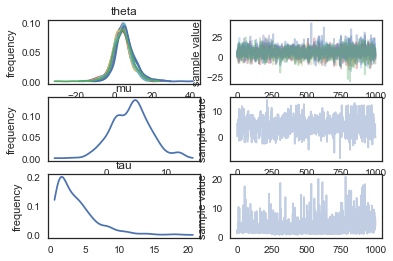

In [23]:
#HMC sampling
sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=500, chains=4)

print(fit)
fit.plot()
plt.show()

## STAN VI (for reference)

In [24]:
fitvi = sm.vb(data=schools_dat, iter=10000000, tol_rel_obj=0.00001)

print(fitvi["args"])
pd.DataFrame(np.array(fitvi["sampler_params"]).T).rename(
    columns=dict(enumerate(fitvi["sampler_param_names"]))).describe()

{'random_seed': '1806341205', 'chain_id': 1, 'init': b'random', 'init_radius': 2.0, 'enable_random_init': False, 'append_samples': False, 'sample_file': b'/tmp/tmp5vl3coym/output.csv', 'method': 'VARIATIONAL', 'iter': 10000000, 'grad_samples': 1, 'elbo_samples': 100, 'eval_elbo': 100, 'output_samples': 1000, 'eta': 1.0, 'adapt_engaged': True, 'adapt_iter': 50, 'tol_rel_obj': 1e-05, 'algorithm': 'MEANFIELD'}


,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,mu,tau,10
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0
mean,7.391810,5.246823,3.206683,4.511332,2.177576,3.273307,8.276747,4.881237,3.931572,6.997711,0.0
std,6.268458,5.769997,6.267616,5.861621,5.417504,5.907211,5.605779,6.440640,2.240820,1.909667,0.0
min,-12.408840,-13.063944,-15.487371,-15.267336,-16.324716,-15.309978,-11.452596,-13.712211,-4.124626,3.360214,0.0
25%,3.272241,1.203962,-1.222433,0.761269,-1.381418,-0.618635,4.514816,0.347117,2.464184,5.615672,0.0
50%,7.337981,5.331328,3.109402,4.600883,2.350431,3.278302,8.122299,4.999745,3.999000,6.704447,0.0
75%,11.449102,9.301510,7.451072,8.745654,5.956203,7.078713,11.877398,9.204672,5.454606,7.993168,0.0
max,26.913641,20.459659,22.575433,22.467692,18.243054,22.030136,32.138789,25.629749,11.479826,15.537621,0.0


## Comparison against STAN VI

In [25]:
print("===============VI=================")
print( pd.DataFrame( list(zip(tonumpy(q_theta_loc), tonumpy(softplus(q_theta_scale)))) + \
 [(q_mu_loc.item(), softplus(q_mu_scale).item())]+[(softplus(q_tau_loc).item(), (softplus(q_tau_scale)).item())] ).rename(columns={0: "mean", 1: "sd"}).transpose() )

print("============STAN VI================")
print( pd.DataFrame(np.array(fitvi["sampler_params"]).T).rename(
    columns=dict(enumerate(fitvi["sampler_param_names"]))).describe().transpose()[["mean", "std"]].transpose() )

===============VI=================
             0         1         2         3         4         5         6  \
mean  7.227632  4.931042  3.523183  4.677280  2.759202  3.681530  7.515103   
sd    5.406585  4.939361  5.071684  4.946769  4.697236  4.939866  4.851582   

             7         8         9  
mean  5.100815  4.309612  6.047021  
sd    5.319966  1.747711  1.194113  
============STAN VI================
       theta.1   theta.2   theta.3   theta.4   theta.5   theta.6   theta.7  \
mean  7.391810  5.246823  3.206683  4.511332  2.177576  3.273307  8.276747   
std   6.268458  5.769997  6.267616  5.861621  5.417504  5.907211  5.605779   

       theta.8        mu       tau   10  
mean  4.881237  3.931572  6.997711  0.0  
std   6.440640  2.240820  1.909667  0.0  


# VI vs LCVI: Posteriors comparison

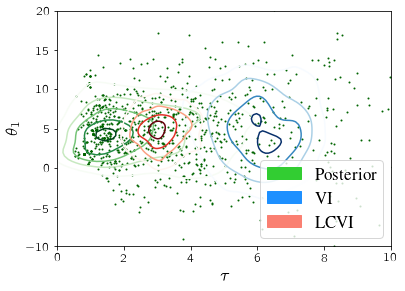

In [26]:
nsamples = 1000
theta_no = 1
n_levels = 4

start_plotting(font_size=17, left=0.175)
label_patches = []

x, y = (fit.extract()["tau"]), fit.extract()["theta"][:,theta_no]
sns.kdeplot(x, y, n_levels=int(n_levels*1.3), shade=False, cmap="Greens");
label_patches.append(mpatches.Patch(color="limegreen",label="Posterior")) 
plt.scatter(x, y, s=1, color="darkgreen")

tau = np.array([softplus(q_tau_vi.sample()).item() for _ in range(nsamples)])
theta = np.array([q_theta_vi.sample()[theta_no].item() for _ in range(nsamples)])
sns.kdeplot(tau, theta, n_levels=n_levels, shade=False, cmap="Blues")
label_patches.append(mpatches.Patch(color="dodgerblue",label="VI")) 

tau = np.array([softplus(q_tau_lcvi.sample()).item() for _ in range(nsamples)])
theta = np.array([q_theta_lcvi.sample()[theta_no].item() for _ in range(nsamples)])
sns.kdeplot(tau, theta, n_levels=n_levels, shade=False, cmap="Reds")
label_patches.append(mpatches.Patch(color="salmon",label="LCVI")) 

plt.xlabel(r"$\tau$");plt.ylabel(r"$\theta_%i$" % theta_no); #plt.legend();
plt.legend(handles=label_patches, loc='lower right', fontsize=17);
plt.grid(False); plt.xlim((0, 10)); plt.ylim((-10,20));
plt.show()

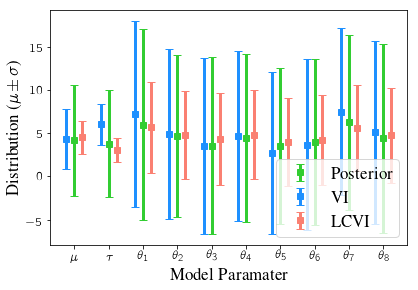

In [27]:
_t = lambda d: list(np.array(d)[-1,]) if np.array(d)[-1,].shape!=() else [np.array(d)[-1,]]

locs_vi = _t(trajectory_vi["qmu_loc"])+_t(trajectory_vi["qtau_loc"])+_t(trajectory_vi["qtheta_loc"])
scales_vi = _t(trajectory_vi["qmu_scale"])+_t(trajectory_vi["qtau_scale"])+_t(trajectory_vi["qtheta_scale"])

locs_lcvi = _t(trajectory_lcvi["qmu_loc"])+_t(trajectory_lcvi["qtau_loc"])+_t(trajectory_lcvi["qtheta_loc"])
scales_lcvi = _t(trajectory_lcvi["qmu_scale"])+_t(trajectory_lcvi["qtau_scale"])+_t(trajectory_lcvi["qtheta_scale"])

locs_true = [fit.extract()["mu"].mean(), fit.extract()["tau"].mean()]+[fit.extract()["theta"][:,i].mean() 
                                                                       for i in range(8)]
scales_true = [fit.extract()["mu"].std(), fit.extract()["tau"].std()]+[fit.extract()["theta"][:,i].std() 
                                                                       for i in range(8)]

names = [r"$\mu$", r"$\tau$"] + [(r"$\theta_%i$" % i) for i in range(1,9)]


start_plotting(font_size=17)

x = np.array(range(len(locs_vi)))

plt.errorbar(x, locs_true, yerr=np.array(scales_true)*2, label="Posterior",
             fmt='-s', lw=0, color=GREEN, ecolor=GREEN, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.errorbar(x-0.23, locs_vi, yerr=np.array(scales_vi)*2, label="VI",
             fmt='-s', lw=0, color=BLUE, ecolor=BLUE, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)

plt.errorbar(x+0.23, locs_lcvi, yerr=np.array(scales_lcvi)*2, label="LCVI",
             fmt='-s', lw=0, color=RED, ecolor=RED, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)


plt.xticks(x, names)
plt.ylabel("Distribution ($\mu  \pm \sigma$)")
plt.xlabel("Model Paramater")
plt.legend(loc=4,fontsize=17);

In [28]:
def sample_predictive_y0_HMC(data, theta, nsamples_y=100):
    sigma = torch.tensor(data["sigma"], dtype=torch.float32)        
    ys = Normal(theta, sigma).rsample(torch.Size([nsamples_y]))    
    return ys


def sample_predictive_y_HMC(data, theta, nsamples_y=100):
    ys = sample_predictive_y0_HMC(data, theta, nsamples_y)
    return ys.transpose(0,2).reshape(data["J"],-1).transpose(0,1) #TODO clean it up

In [29]:
ys_true = sample_predictive_y_HMC(schools_dat, torch.tensor(fit.extract()["theta"], dtype=torch.float32), 500)
ys_vi = sample_predictive_y(schools_dat, q_theta_vi, 1000, 500)
ys_lcvi = sample_predictive_y(schools_dat, q_theta_lcvi, 1000, 500)

y_true_locs, y_true_scales = [], []
y_true_h = []
y_vi_locs, y_vi_scales = [], []
y_vi_h = []
y_lcvi_locs, y_lcvi_scales = [], []
y_lcvi_h = []
names = []
for j in range(8):
    names.append(r"$y_%i$" % (j+1))
    
    y_true_locs.append(ys_true[:,j].mean().item())
    y_true_scales.append(ys_true[:,j].std().item())    
    y_true_h.append(optimal_h(ys_true[:,j]).item())
    
    y_vi_locs.append(ys_vi[:,j].mean().item())
    y_vi_scales.append(ys_vi[:,j].std().item())    
    y_vi_h.append(optimal_h(ys_vi[:,j]).item())    
    
    y_lcvi_locs.append(ys_lcvi[:,j].mean().item())
    y_lcvi_scales.append(ys_lcvi[:,j].std().item())
    y_lcvi_h.append(optimal_h(ys_lcvi[:,j]).item())


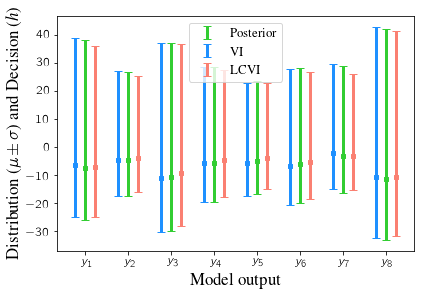

In [30]:
start_plotting()

x = np.array(range(len(y_vi_locs)))
offset = 0.23

plt.errorbar(x, y_true_locs, yerr=np.array(y_true_scales)*2, label="Posterior",
             fmt='-', lw=0, color=GREEN, ecolor=GREEN, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)
plt.scatter(x, y_true_h, color=GREEN, marker="s", s=20)

plt.errorbar(x-offset, y_vi_locs, yerr=np.array(y_vi_scales)*2, label="VI",
             fmt='-', lw=0, color=BLUE, ecolor=BLUE, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)
plt.scatter(x-offset, y_vi_h, color=BLUE, marker="s", s=20)

plt.errorbar(x+offset, y_lcvi_locs, yerr=np.array(y_lcvi_scales)*2, label="LCVI",
             fmt='-', lw=0, color=RED, ecolor=RED, elinewidth=3, capsize=4, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False)
plt.scatter(x+offset, y_lcvi_h, color=RED, marker="s", s=20)


plt.xticks(x, names)
plt.ylabel(r"Distribution ($\mu  \pm \sigma$) and Decision ($\textit{h}$)")
plt.xlabel("Model output")
plt.legend();


# Convergence plot

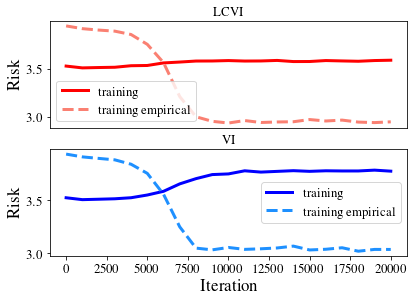

In [31]:
COLS = dict(enumerate("t, utility_term, SEED, iter, elbo, training_rmse, training_risk, training_loss, training_gain, training_util, test_rmse, test_risk, test_loss, test_gain, test_util".split(", ")))
report_vi_df = pd.DataFrame(report_vi)
report_vi_df.rename(columns=COLS, inplace=True)
report_lcvi_df = pd.DataFrame(report_lcvi)
report_lcvi_df.rename(columns=COLS, inplace=True)


start_plotting(cmbright=False)

ax1 = plt.subplot(211)
plt.title("LCVI")
plt.plot(report_lcvi_df.iter, (report_lcvi_df.training_risk),
         label = "training", lw=3, color="red")
plt.plot(report_lcvi_df.iter, (report_lcvi_df.training_loss),
         label = "training empirical", lw=3, color="salmon", ls="--")
plt.ylabel("Risk")
plt.xticks([],[])
plt.legend()
#plt.ylim(0.235, 0.34)

ax2 = plt.subplot(212)
plt.title("VI")
plt.plot(report_vi_df.iter, (report_vi_df.training_risk),
         label = "training", lw=3, color="blue")
plt.plot(report_vi_df.iter, (report_vi_df.training_loss),
         label = "training empirical", lw=3, color="dodgerblue", ls="--")
plt.xlabel("Iteration"); plt.ylabel("Risk"); 
plt.grid(False); plt.legend(); plt.show();
#plt.ylim(0.235, 0.34)